In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline

def display_images(im1, im2=None):
    if im2 is not None:
        # Acquire default dots per inch value of matplotlib
        dpi = matplotlib.rcParams['figure.dpi']

        # Determine the figures size in inches to fit your image
        height, width, depth = im1.shape
        figsize = width * 2 / float(dpi), height / float(dpi)
        f, axarr = plt.subplots(1, 2, figsize=figsize)
        axarr[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
        axarr[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        # Acquire default dots per inch value of matplotlib
        dpi = matplotlib.rcParams['figure.dpi']

        # Determine the figures size in inches to fit your image
        height, width, depth = im1.shape
        figsize = width / float(dpi), height / float(dpi)
        plt.figure(figsize=figsize)
        plt.imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

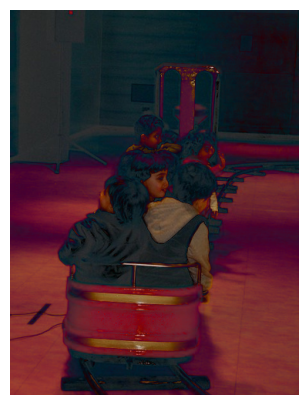

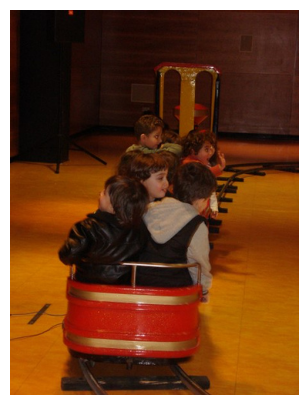

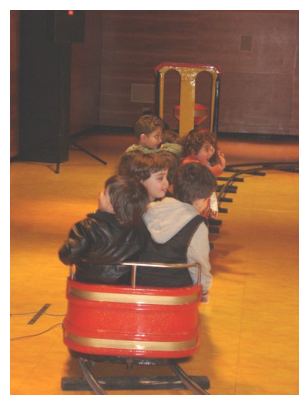

In [14]:
path = "coco/images/val2017_original/000000001353.jpg"
image = cv.imread(path)
alpha = 1 # Simple contrast control
beta = 0   # Simple brightness control
# new_image = cv.convertScaleAbs(image, alpha, beta)
# display_images(new_image)
for beta in [-50, 0, 50]:
# for alpha in [0.5, 1, 2]:
    new_image = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
    display_images(new_image)

In [3]:
# from pathlib import Path
# import os
# import shutil
# import tqdm

# alpha = 1 # Simple contrast control
# beta = 50  # Simple brightness control

# fpath = "coco/images/val2017_original/"
# fout = f"coco/images/val2017_{alpha}_{beta}/"
# Path(fout).mkdir(parents=True, exist_ok=True)

# for f in tqdm.tqdm(os.listdir(fpath)):
#   image = cv.imread(fpath + f)
#   new_image = cv.convertScaleAbs(image, alpha, beta)
#   cv.imwrite(fout + f, new_image)

In [4]:
import random

def generate_random_lines(num_lines,imshape,slant,drop_length):
    drops=[]    
    for i in range(num_lines):
        if slant<0:
            x= np.random.randint(slant,imshape[1])        
        else:            
            x= np.random.randint(0,imshape[1]-slant)        
        y= np.random.randint(0,imshape[0]-drop_length)        
        drops.append((x,y))    
    return drops    
                    
def add_rain(original,num_rain,rain_alpha):     
    image = original.copy() 
    imshape = image.shape
    slant_extreme=10    
    slant= np.random.randint(-slant_extreme,slant_extreme)
    drop_length=20    
    drop_width=2    
    drop_color=(200,200,200) ## a shade of gray    
    rain_drops= generate_random_lines(num_rain,imshape,slant,drop_length)
    for rain_drop in rain_drops:        
        image = cv.line(image,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)
    image = cv.addWeighted(image, rain_alpha, original, 1 - rain_alpha, 0)  
    return image
    
def gen_haze(img, depth_img, beta):
    norm_depth_img = (255-depth_img)/255
    trans = np.exp(-norm_depth_img*beta)

    A = 255
    hazy = img*trans + A*(1-trans)
    hazy = np.array(hazy, dtype=np.uint8)
    
    return hazy

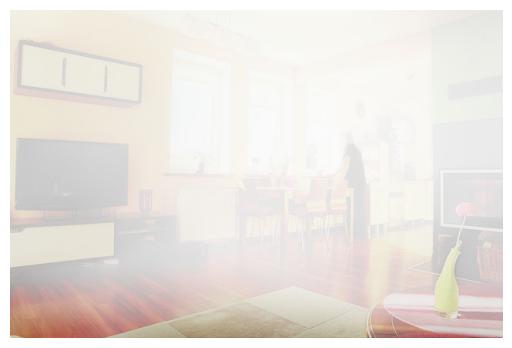

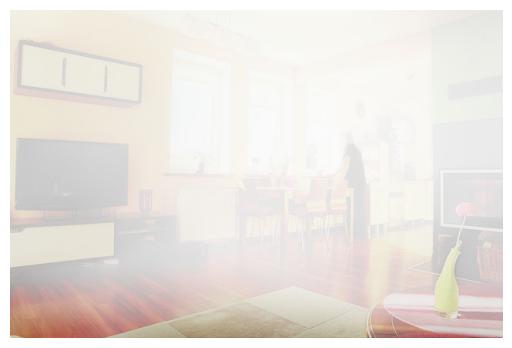

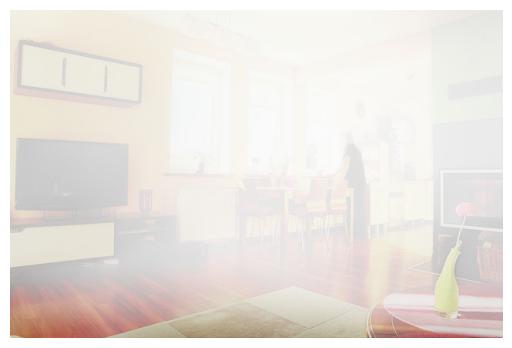

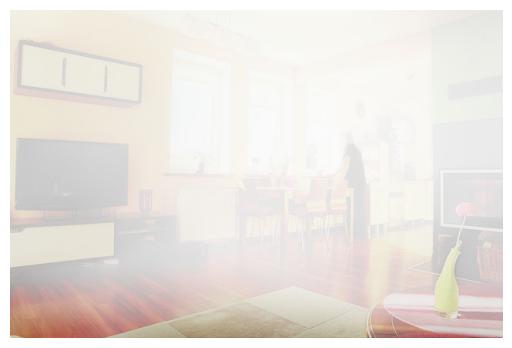

In [7]:
path = "coco/images/val2017_original/000000000139.jpg"
image = cv.imread(path)
depth_path = "coco/images/val2017_depth/000000000139.png"
depth_image = cv.imread(depth_path)
if depth_image is None:
    depth_image = np.ones([image.shape[0], image.shape[1], 3]) * 128
else:
    depth_image = cv.resize(depth_image, [image.shape[1], image.shape[0]])

beta = 4
rain_alpha = 0
num_rain = 0
# for beta in [0, 1, 2]:
# for num_rain, rain_alpha in [[500, 0.1], [1000, 0.1], [500, 0.25]]:
for i in range(1):
    new_image = add_rain(image, num_rain=num_rain, rain_alpha=rain_alpha)
    new_image = gen_haze(new_image, depth_image, beta=beta)
    display_images(new_image)

In [10]:
from pathlib import Path
import os
import shutil
import tqdm

rain_density = 0 # Number of rain streaks
alpha = 0 # Opacity of rain, 0-1
beta = 4  # Opacity of fog (eg. 1.25)

fpath = "coco/images/val2017_original/"
dpath = "coco/images/val2017_depth/"
fout = f"coco/images/val2017_{rain_density}_{alpha}_{beta}/"
Path(fout).mkdir(parents=True, exist_ok=True)

random.seed(0)
np.random.seed(0)

for f in tqdm.tqdm(os.listdir(fpath)):
  if ".jpg" not in f:
    continue
  image = cv.imread(fpath + f)
  depth_path = Path(dpath + f.split('.jpg')[0] + '.png')
  if depth_path.exists():
    depth_image = cv.imread(str(depth_path))
  else:
    depth_image = np.ones([640, 480, 3]) * 128
  depth_image = cv.resize(depth_image, [image.shape[1], image.shape[0]])
  if rain_density > 0 and alpha > 0:
    image = add_rain(image, num_rain=rain_density, rain_alpha=alpha)
  if beta > 1:
    image = gen_haze(image, depth_image, beta=beta)
  cv.imwrite(fout + f, image)

100%|██████████| 5000/5000 [01:23<00:00, 60.04it/s]


In [ ]:
# %%bash
# for i in {96..640..32}; 
# do 
# python test.py --data data/coco.yaml --img $i --batch 32 --conf 0.001 --iou 0.65 --device 0 --weights yolov7.pt --name "yolov7_$i_val">> output_rain_1000_0.25_0.25.txt; 
# done